%config Completer.use_jedi = False

In [43]:
from __future__ import division, print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
from imageio import imread, imsave
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.color import rgb2gray
import skimage.io as io
from skimage.feature import plot_matches

# Homework 4

In [4]:
def plot_imageset(images, figsize=(12, 10)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.1)

    for ax, im in zip(grid, images):
        ax.set_axis_off()
        if len(im.shape) < 3:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)

    plt.show()

### Load and preprocess images

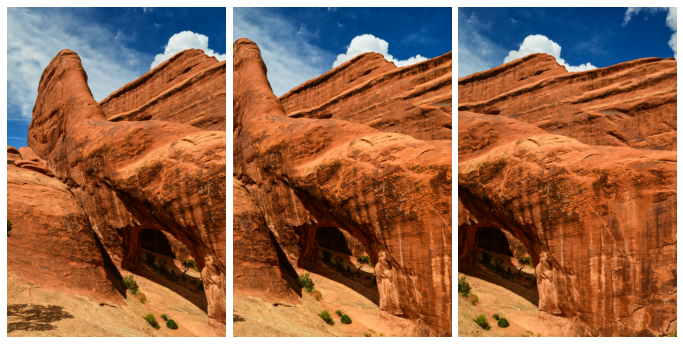

In [5]:

pano_paths = sorted(glob.glob('data/JDW_03*'))

pano_imgs = [imread(path) for path in pano_paths]

plot_imageset(pano_imgs)

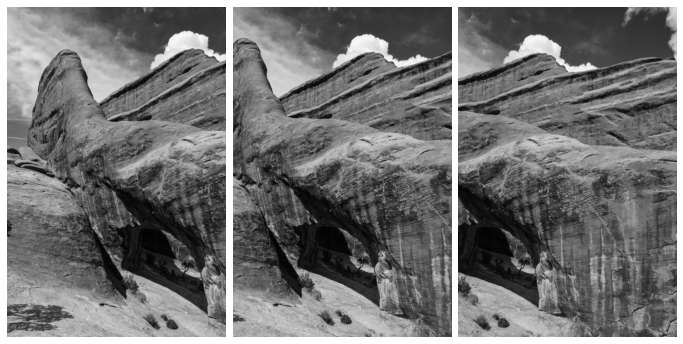

In [6]:
# Convert to grayscale
pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]
plot_imageset([pano0, pano1, pano2], figsize=(12, 10))

In [19]:
img_list = [pano0, pano1, pano2]

# Detect features and plot matches

In [20]:
from skimage.feature import ORB

keypoint_list = []
descriptor_list = []

for pano in img_list:
    orb = ORB(n_keypoints=800, fast_threshold=0.05)    
    orb.detect_and_extract(pano)
    keypoints0 = orb.keypoints
    descriptors0 = orb.descriptors
    keypoint_list.append(keypoints0)
    descriptor_list.append(descriptors0)
    
    
# skimage
# orb = ORB(n_keypoints=800, fast_threshold=0.05)

#cv2 
#orb = cv2.ORB_create()
#sift = cv2.SIFT_create()

#skimage
# orb.detect_and_extract(pano0)
# keypoints0 = orb.keypoints
# descriptors0 = orb.descriptors

# cv2
#keypoints0, descriptors0 = orb.detectAndCompute(pano0, None)



In [82]:
# Match the descriptors 

# skimage: from skimage.feature import match_descriptors
# opencv: easiest is probably cv2.BFMatcher

from skimage.feature import match_descriptors

match_0_1 = match_descriptors(descriptor_list[0],
                            descriptor_list[1])


match_1_2 = match_descriptors(descriptor_list[1],
                            descriptor_list[2])

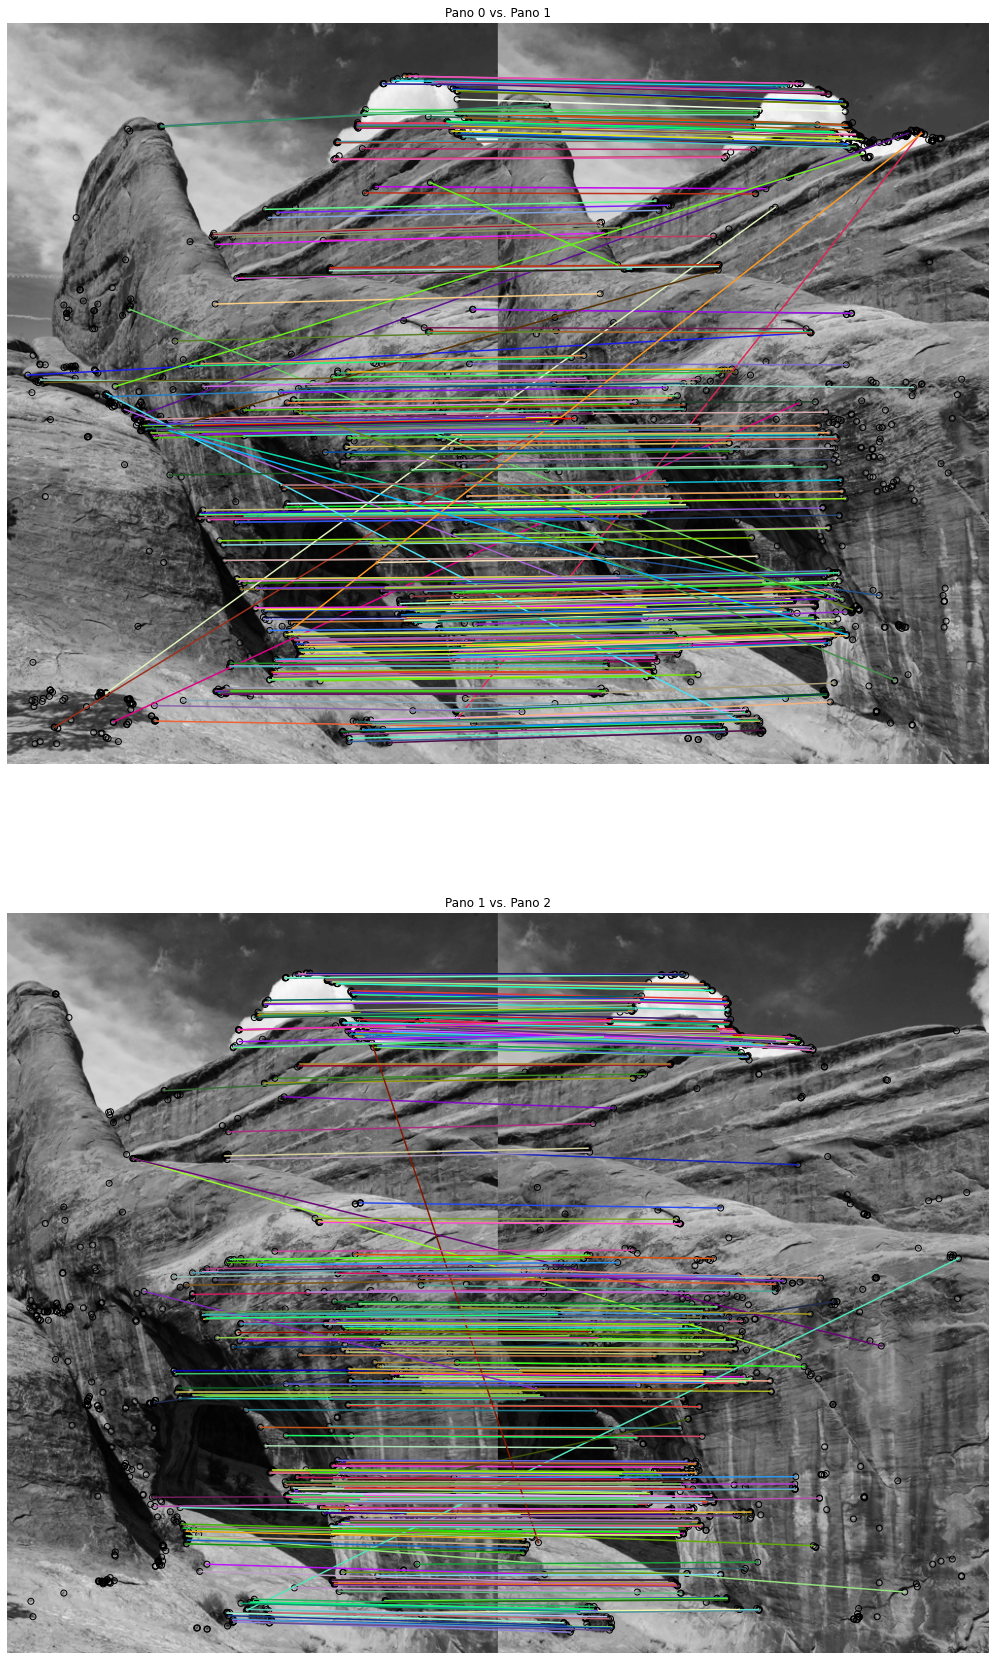

In [87]:
# do this for both 0->1 and 2->1
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,30))

plt.gray()

plot_matches(ax[0], pano0, pano1, keypoint_list[0], keypoint_list[1], match_0_1)
ax[0].axis('off')
ax[0].set_title("Pano 0 vs. Pano 1")

plot_matches(ax[1], pano1, pano2, keypoint_list[1], keypoint_list[2], match_1_2)
ax[1].axis('off')
ax[1].set_title("Pano 1 vs. Pano 2")


plt.show()

## Answer to Problem 2

Points where the pixles around the point are very uniform. In other words, the gradient from interested points are very similar, not variant across all directions.

# Homography + RANSAC

In [86]:
# skimage functions to look at:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac


#opencv: cv2.findHomography with cv2.RANSAC

model_0_1, inliers_0_1 = ransac((keypoint_list[0][match_0_1[:, 0]][:, ::-1],
                         keypoint_list[1][match_0_1[:, 1]][:, ::-1]),
                        ProjectiveTransform, min_samples=8,
                        residual_threshold=1, max_trials=5000)


model_1_2, inliers_1_2 = ransac((keypoint_list[2][match_1_2[:, 1]][:, ::-1],
                         keypoint_list[1][match_1_2[:, 0]][:, ::-1]),
                        ProjectiveTransform, min_samples=8,
                        residual_threshold=1, max_trials=5000)


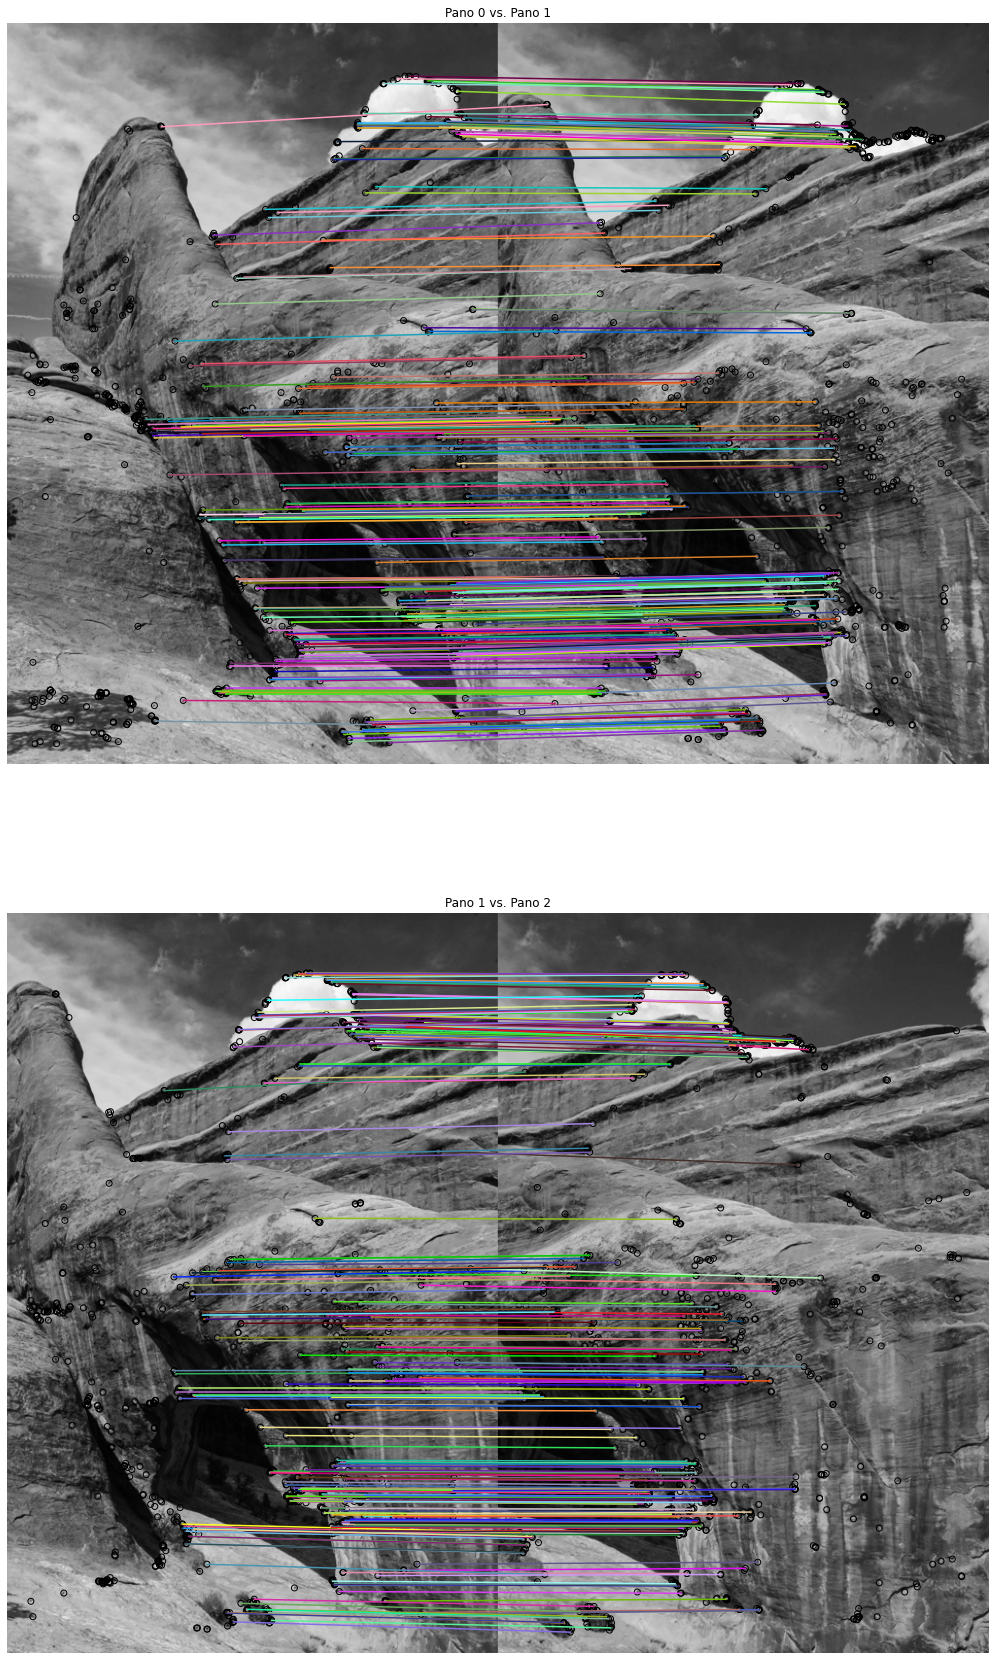

In [90]:
# plotting the inliers for homography estimation with ransac.  looks much better!

# Visualize the results.

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(30,30))

plt.gray()

plot_matches(ax[0], pano0, pano1, keypoint_list[0], keypoint_list[1],
             match_0_1[inliers_0_1])
ax[0].axis("off")
ax[0].set_title("Pano 0 vs. Pano 1")

plot_matches(ax[1], pano1, pano2, keypoint_list[1], keypoint_list[2],
             match_1_2[inliers_1_2])
ax[1].axis("off")
ax[1].set_title("Pano 1 vs. Pano 2")


plt.show() 

## Answer to question 3:

All the outliers has been removed

# Panorama Warp


In [91]:
# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_0_1(corners)# apply transform0->1 to corners
warped_corners12 = model_1_2(corners)# apply transform1->2 to corners

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

In [92]:
output_shape

array([816, 812])

In [93]:
corner_min

array([-142.60563631,  -66.31560579])

In [94]:
corner_max

array([668.87921414, 749.65939826])

### Applying the warps

In [95]:
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from cv2 import warpAffine
from cv2 import warpPerspective

In [199]:
# Use one of the quantities computed above to find the correct offset for middle image
offset1 = SimilarityTransform(translation= (0-corner_min) )#

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse,
                    output_shape=output_shape)# apply offset with an affine transform function, make sure the correct output_shape is specified

# Get the validity mask for this image
pano1_mask = (pano1_warped != 0)# 

In [200]:
offset0 = ProjectiveTransform(matrix = (offset1.params).dot(model_0_1.params))
#offset0 = model_0_1 + offset1

# Warp the left image into place
pano0_warped = warp(pano0, offset0.inverse, 
                    output_shape=output_shape )#
pano0_mask = (pano0_warped != 0) # 
  

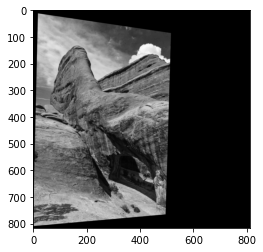

In [201]:
plt.imshow(pano0_warped)

In [202]:
# Warp the right image into place
offset2 = ProjectiveTransform(matrix = (offset1.params).dot(model_1_2.params))
pano2_warped = warp(pano2, offset2.inverse, 
                    output_shape=output_shape)#
pano2_mask = (pano2_warped != 0)#

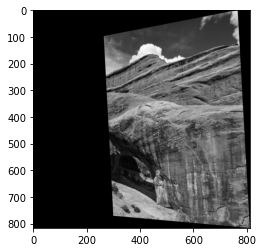

In [203]:
plt.imshow(pano2_warped)

# Blend images into panorama

In [ ]:
# use [pano0_warped, pano1_warped, pano2_warped] and [pano0_mask, pano1_mask, pano2_mask]
# to obtain normalized panorama image

In [204]:
merged_pic = pano0_warped+pano1_warped+pano2_warped
merged_mask = pano0_mask*1.0+pano1_mask*1.0+pano2_mask*1.0
merged_mask = merged_mask.astype(float)

In [205]:
pic = merged_pic / merged_mask

/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(-0.5, 811.5, 815.5, -0.5)

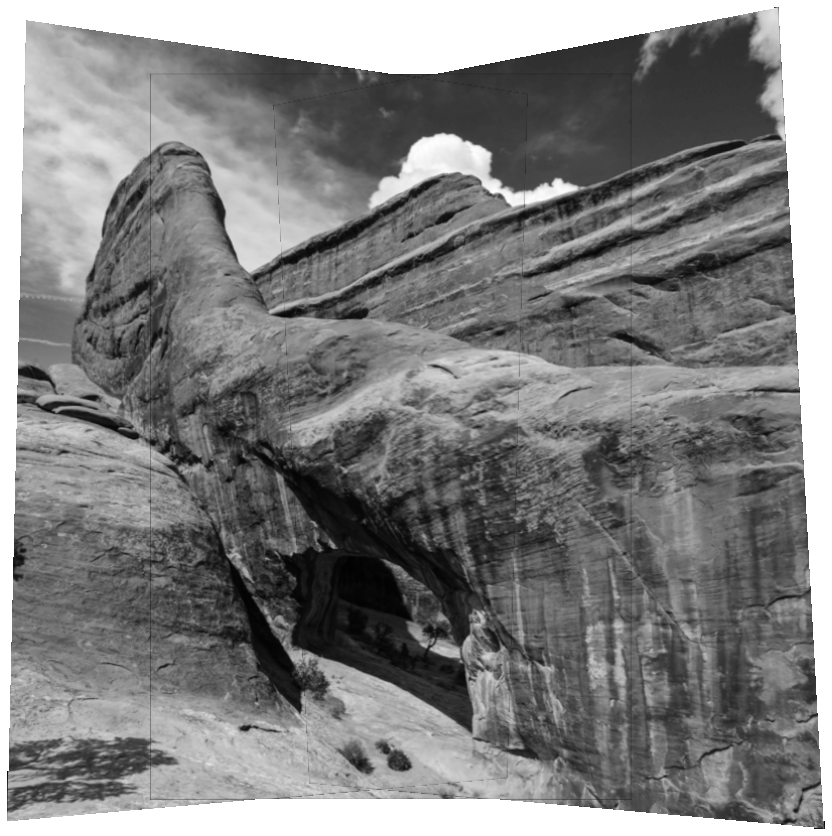

In [206]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(pic, cmap='gray')

plt.tight_layout()
ax.axis('off')

In [164]:
pano0_color = warp(pano_imgs[0], offset0.inverse,
                   output_shape=output_shape)

pano1_color = warp(pano_imgs[1], offset1.inverse,
                   output_shape=output_shape)

pano2_color = warp(pano_imgs[2], offset2.inverse,
                   output_shape=output_shape)

In [207]:
merged_pic_color = pano0_color+pano1_color+pano2_color

In [208]:
colored_pic = merged_pic_color/ merged_mask[:,:,np.newaxis]

/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(-0.5, 811.5, 815.5, -0.5)

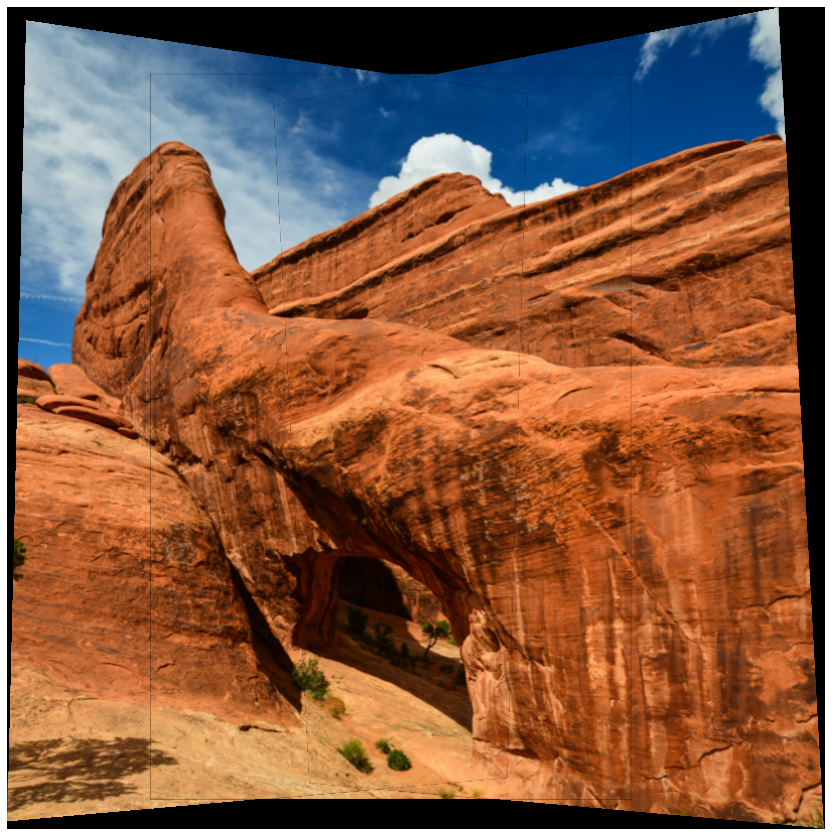

In [209]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(colored_pic)

plt.tight_layout()
ax.axis('off')

# Hough Transform

## Problem 5

Voting space is (a,b,u,v,$\theta$)

a: is the length of half of the width of the ellipse (2a is the width of the elipse), the axis of width is parallel to the x-axis if there is no rotation. The range of a is from 0 to $\frac{\sqrt{2}}{2} N$

b: is the length of half of the height of the ellipse (2b is the height of the elipse), the axis of height is parallel to the y-axis if there is no rotation. The range of b is from 0 to $\frac{\sqrt{2}}{2} N$

u: is the translation in x-axis. The range of u is from $-N/2$ to $N/2$

v: is the translation in y-axis. The range of v is from $-N/2$ to $N/2$

$\theta$: is the rotation angle counter-clockwise from x-axis. The range of $\theta$ is from 0 to $2\pi$

$ -\frac{N}{2} \leq a*cos(\theta) + u \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -a*cos(\theta) + u \leq \frac{N}{2} $ 

$ -\frac{N}{2} \leq a*sin(\theta) + v \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -a*sin(\theta) + v \leq \frac{N}{2} $ 

$ -\frac{N}{2} \leq b*sin(\theta) + u \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -b*sin(\theta) + u \leq \frac{N}{2} $ 

$ -\frac{N}{2} \leq b*cos(\theta) + v \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -b*cos(\theta) + v \leq \frac{N}{2} $ 

## Problem 6

Formula for Hough transform:

Basic ellipse: $\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1$

Apply translation: $\frac{(x-u)^2}{a^2} + \frac{(y-v)^2}{b^2} = 1$

Apply rotation: $\frac{[(x-u)*\cos{\theta}-(y-v)*\sin{\theta}]^2}{a^2} + \frac{[(y-v)*\cos{\theta}+(x-u)*\sin{\theta}]^2}{b^2} = 1$

For all the pixle (x,y), accumulate all the possible (a,b,u,v,$\theta$) satisfy all the restriction mentioned in Problem 5

## Problem 7

Now the voting space is reduced from 5 dimensions to 4 dimensions. Voting space: (b,u,v,$\theta$)

Assume aspect ratio is known as k.

Formula for Hough transform:

$\frac{[(x-u)*\cos{\theta}-(y-v)*\sin{\theta}]^2}{(k*b)^2} + \frac{[(y-v)*\cos{\theta}+(x-u)*\sin{\theta}]^2}{b^2} = 1$

The new range restriction:


$ -\frac{N}{2} \leq kb*cos(\theta) + u \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -kb*cos(\theta) + u \leq \frac{N}{2} $ 

$ -\frac{N}{2} \leq kb*sin(\theta) + v \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -kb*sin(\theta) + v \leq \frac{N}{2} $ 

$ -\frac{N}{2} \leq b*sin(\theta) + u \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -b*sin(\theta) + u \leq \frac{N}{2} $ 

$ -\frac{N}{2} \leq b*cos(\theta) + v \leq \frac{N}{2} $, $ -\frac{N}{2} \leq -b*cos(\theta) + v \leq \frac{N}{2} $ 

This assumes the major axis is parallel to the x-axis and the minor axis is parallel to the y-axis.

This assumption is valid as if the major axis is parallel to the y-axis and the minor axis is parallel to the x-axis, this ellipse is the pre-defined ellipse with rotation angle $\theta = \frac{1}{2}\pi$